<a href="https://colab.research.google.com/github/rahuls321/Time-Series-Forecasting-With-Python/blob/master/Feature_Selection_for_TSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


            Sales
Month            
1960-01-01   6550
1960-02-01   8728
1960-03-01  12026
1960-04-01  14395
1960-05-01  14587


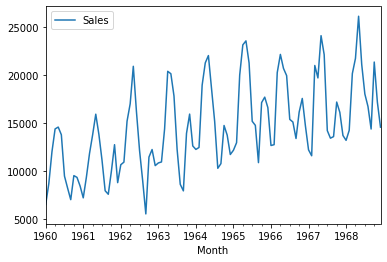

In [3]:
from pandas import read_csv
from matplotlib import pyplot
series = read_csv('gdrive/My Drive/Colab Notebooks/Forecasting_Datasets/monthly-car-sales.csv', header=0, index_col="Month", parse_dates=True)
print(series.head())
series.plot()
pyplot.show()

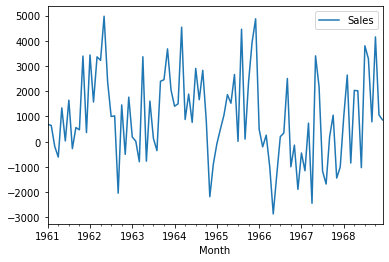

In [4]:
# seasonal difference
differenced = series.diff(12)
# trim off the first year of empty data
differenced = differenced[12:]
# save differenced dataset to file
differenced.to_csv('seasonally_adjusted.csv', index=False)
# plot differenced dataset
differenced.plot()
pyplot.show()

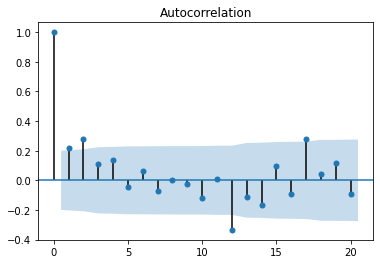

In [7]:
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf
import pandas.util.testing as tm
from matplotlib import pyplot

series = read_csv('seasonally_adjusted.csv', header=0)
plot_acf(series)
pyplot.show()

The plot shows lag values along the x-axis and correlation on the y-axis between -1 and 1 for negatively and positively correlated lags respectively.

The dots above the blue area indicate statistical significance. The correlation of 1 for the lag value of 0 indicates 100% positive correlation of an observation with itself.

The plot shows significant lag values at 1, 2, 12, and 17 months.

##Time Series To Supervised Learning

In [12]:
from pandas import DataFrame

# reframe as supervised learning
dataframe = DataFrame()
for i in range(12,0,-1):
	dataframe['t-'+str(i)] = series.shift(i).values[:,0]
dataframe['t'] = series.values[:,0]
print(dataframe.head(13))
dataframe = dataframe[13:]
# save to new file
dataframe.to_csv('lags_12months_features.csv', index=False)

     t-12   t-11   t-10    t-9     t-8  ...     t-4     t-3     t-2     t-1       t
0     NaN    NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN     NaN   687.0
1     NaN    NaN    NaN    NaN     NaN  ...     NaN     NaN     NaN   687.0   646.0
2     NaN    NaN    NaN    NaN     NaN  ...     NaN     NaN   687.0   646.0  -189.0
3     NaN    NaN    NaN    NaN     NaN  ...     NaN   687.0   646.0  -189.0  -611.0
4     NaN    NaN    NaN    NaN     NaN  ...   687.0   646.0  -189.0  -611.0  1339.0
5     NaN    NaN    NaN    NaN     NaN  ...   646.0  -189.0  -611.0  1339.0    30.0
6     NaN    NaN    NaN    NaN     NaN  ...  -189.0  -611.0  1339.0    30.0  1645.0
7     NaN    NaN    NaN    NaN     NaN  ...  -611.0  1339.0    30.0  1645.0  -276.0
8     NaN    NaN    NaN    NaN   687.0  ...  1339.0    30.0  1645.0  -276.0   561.0
9     NaN    NaN    NaN  687.0   646.0  ...    30.0  1645.0  -276.0   561.0   470.0
10    NaN    NaN  687.0  646.0  -189.0  ...  1645.0  -276.0   561.0   470.0 

##Feature Importance of Lag Variables

The example below loads the supervised learning view of the dataset created in the previous section, fits a random forest model (RandomForestRegressor), and summarizes the relative feature importance scores for each of the 12 lag observations.

[0.21642244 0.06271259 0.05662302 0.05543768 0.07155573 0.08478599
 0.07699371 0.05366735 0.1033234  0.04897883 0.1066669  0.06283236]


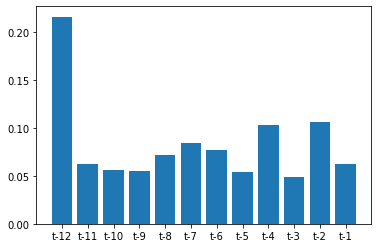

In [13]:
from pandas import read_csv
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load data
dataframe = read_csv('lags_12months_features.csv', header=0)
array = dataframe.values
# split into input and output
X = array[:,0:-1]
y = array[:,-1]
# fit random forest model
model = RandomForestRegressor(n_estimators=500, random_state=1)
model.fit(X, y)
# show importance scores
print(model.feature_importances_)
# plot importance scores
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, model.feature_importances_)
pyplot.xticks(ticks, names)
pyplot.show()

The plot shows the high relative importance of the observation at t-12 and, to a lesser degree, the importance of observations at t-2 and t-4.

##Feature Selection of Lag Variables

The example below uses RFE(Recursive Feature Selection) with a random forest predictive model and sets the desired number of input features to 4.

Selected Features:
t-12
t-6
t-4
t-2


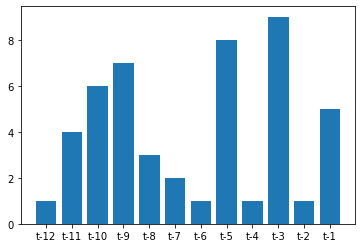

In [14]:
from pandas import read_csv
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
# load dataset
dataframe = read_csv('lags_12months_features.csv', header=0)
# separate into input and output variables
array = dataframe.values
X = array[:,0:-1]
y = array[:,-1]
# perform feature selection
rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), n_features_to_select=4)
fit = rfe.fit(X, y)
# report selected features
print('Selected Features:')
names = dataframe.columns.values[0:-1]
for i in range(len(fit.support_)):
	if fit.support_[i]:
		print(names[i])
# plot feature rank
names = dataframe.columns.values[0:-1]
ticks = [i for i in range(len(names))]
pyplot.bar(ticks, fit.ranking_)
pyplot.xticks(ticks, names)
pyplot.show()